In [ ]:
# This is Mudhawi Saleh Alshiha
# FIFA World Cup Analysis (1930–2022)
# In this notebook, I explore match and tournament data from the FIFA World Cups to uncover trends, team performance, and championship paths.


In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
# 1. Load & Store Data

In [ ]:
# Load the match-level data from 1930 to 2022 & the World Cup summary data (champions, hosts, etc.)

matches = pd.read_csv("/Users/madhawialshiha/Downloads/footballdatasets/matches_1930_2022.csv")
cups = pd.read_csv("/Users/madhawialshiha/Downloads/footballdatasets/world_cup.csv")


In [ ]:
# Needed to create a local SQLite connection so we can store the data

conn = sqlite3.connect("/Users/madhawialshiha/Documents/worldcup.db")


In [ ]:
# Here we are saving both datasets to SQLite table

matches.to_sql("matches", conn, if_exists="replace", index=False)
cups.to_sql("cups", conn, if_exists="replace", index=False)


22

In [ ]:
# We want to know each year how many matches were played

query = """
SELECT Year, COUNT(*) as Match
FROM matches
GROUP BY Year
ORDER BY Year
"""

result = pd.read_sql_query(query, conn)
print(result)


    Year  Match
0   1930     18
1   1934     17
2   1938     18
3   1950     22
4   1954     26
5   1958     35
6   1962     32
7   1966     32
8   1970     32
9   1974     38
10  1978     38
11  1982     52
12  1986     52
13  1990     52
14  1994     52
15  1998     64
16  2002     64
17  2006     64
18  2010     64
19  2014     64
20  2018     64
21  2022     64


In [48]:
# This shows the actual column names in your "matches" table
query = "PRAGMA table_info(matches);"
cols = pd.read_sql_query(query, conn)
print(cols[['name']])


                               name
0                         home_team
1                         away_team
2                        home_score
3                           home_xg
4                      home_penalty
5                        away_score
6                           away_xg
7                      away_penalty
8                      home_manager
9                      home_captain
10                     away_manager
11                     away_captain
12                       Attendance
13                            Venue
14                        Officials
15                            Round
16                             Date
17                            Score
18                          Referee
19                            Notes
20                             Host
21                             Year
22                        home_goal
23                        away_goal
24                   home_goal_long
25                   away_goal_long
26                    home_o

In [ ]:
# We want to make sure to save the cleaned match data (that includes:goals and result) into a new SQL table

query = """
CREATE TABLE IF NOT EXISTS clean_matches AS
SELECT *,
       home_goal + away_goal AS total_goals,
       CASE
           WHEN home_goal > away_goal THEN home_team
           WHEN home_goal < away_goal THEN away_team
           ELSE 'Draw'
       END AS match_result
FROM matches
"""
conn.execute(query)
conn.commit()
print("Table 'clean_matches' created.")


Table 'clean_matches' created.


In [ ]:
# Function to count us the number of goals from goal description
def count_goals(goal_string):
    if pd.isna(goal_string) or goal_string.strip() == "":
        return 0
    return len(goal_string.split("|"))

# Apply to matches
matches['home_goal_count'] = matches['home_goal'].apply(count_goals)
matches['away_goal_count'] = matches['away_goal'].apply(count_goals)

# Create a total goals column
matches['total_goals'] = matches['home_goal_count'] + matches['away_goal_count']

# Create match result column
def determine_result(row):
    if row['home_goal_count'] > row['away_goal_count']:
        return row['home_team']
    elif row['home_goal_count'] < row['away_goal_count']:
        return row['away_team']
    else:
        return "Draw"

matches['match_result'] = matches.apply(determine_result, axis=1)


In [ ]:
# Now that we’ve added goal counts and match results, save the updated data to a new SQL table
matches.to_sql("clean_matches", conn, if_exists="replace", index=False)
print("Clean table with goal counts saved.")


Clean table with goal counts saved.


In [ ]:
## Highest Scoring Matches in World Cup History
# Let’s look at the top 10 matches with the highest total goals. This helps identify the most action-packed games and gives insight into offensive trends over the years.


In [53]:
# Query to find the top 10 World Cup matches with the highest combined goal totals
df = pd.read_sql_query("""
SELECT home_team, away_team, home_goal_count, away_goal_count, total_goals
FROM clean_matches
ORDER BY total_goals DESC
LIMIT 10
""", conn)

print(df.to_string(index=False))


  home_team      away_team  home_goal_count  away_goal_count  total_goals
Switzerland        Austria                5                7           12
    Hungary    El Salvador               10                1           11
    Hungary        Germany                8                3           11
     Brazil         Poland                6                4           10
 Yugoslavia          Zaire                9                0            9
     France       Paraguay                7                2            9
    Germany        Türkiye                7                2            9
    Hungary Korea Republic                9                0            9
     Brazil        Germany                1                7            8
    Germany   Saudi Arabia                8                0            8


In [ ]:
# Head-to-Head Rivalry Analysis
# We going to explore the full match history between any two World Cup teams —> including results, goals, and rounds. A mini rivalry deep-dive!



In [54]:
#Analyze and display the rivalry between two World Cup teams
#Outputs match history, total wins, and a simple bar chart of outcomes


def analyze_team_rivalry(team1, team2, conn):
    #Build a SQL query to fetch all matches between the two teams, regardless of (home or away)
    query = f"""
    SELECT
        home_team,
        away_team,
        home_goal_count,
        away_goal_count,
        total_goals,
        match_result,
        Year,
        Round,
        Venue
    FROM clean_matches
    WHERE
        (home_team = '{team1}' AND away_team = '{team2}')
        OR
        (home_team = '{team2}' AND away_team = '{team1}')
    ORDER BY Year
    """
    
    # Execute the SQL and load the results into a DataFrame
    df = pd.read_sql_query(query, conn)
    
    
    # If there are no matches between the teams, show a message and exit
    if df.empty:
        print(f"No matches found between {team1} and {team2}.")
        return
    # Print the full match history in a nice format
    print(f"\n Match History: {team1} vs {team2}")
    print(df.to_string(index=False))

    # Summary statistics: total matches, wins, and draws
    print(f"\n Total Matches: {len(df)}")
    print(f" {team1} Wins:", len(df[df['match_result'] == team1]))
    print(f" {team2} Wins:", len(df[df['match_result'] == team2]))
    print(f" Draws:", len(df[df['match_result'] == 'Draw']))

    # Plot the number of wins and draws using a bar chart
    try:
        import matplotlib.pyplot as plt
        result_counts = df['match_result'].value_counts()
        result_counts.plot(kind='bar', title=f'{team1} vs {team2} - Match Outcomes')
        plt.xlabel('Winner')
        plt.ylabel('Number of Matches')
        plt.show()
    except:
        print(" Could not display chart — matplotlib not available.")


In [55]:
# Recreate the clean_matches table with match_result and total_goals
# Logic:
# - total_goals: sum of home and away goals
# - match_result: the winner or 'Draw' based on goal comparison

query = """
CREATE TABLE IF NOT EXISTS clean_matches AS
SELECT *,
       home_goal_count + away_goal_count AS total_goals,
       CASE
           WHEN home_goal_count > away_goal_count THEN home_team
           WHEN home_goal_count < away_goal_count THEN away_team
           ELSE 'Draw'
       END AS match_result
FROM matches
"""
# Run the SQL command and save the table to the database
conn.execute(query)
conn.commit()


#To confirm the table was updated successfully
print("clean_matches table updated with total_goals and match_result.")


clean_matches table updated with total_goals and match_result.


In [59]:
# Argentina vs France: World Cup Rivalry (an example)
#Let’s explore the historical matches between Argentina and France —> including wins, goals, and tournament stages.



 Match History: Argentina vs France
home_team away_team  home_goal_count  away_goal_count  total_goals match_result  Year       Round                                                            Venue
Argentina    France                1                0            1    Argentina  1930 Group stage                                       Parque Central, Montevideo
Argentina    France                1                1            2         Draw  1978 First round El Monumental - Estadio Monumental Antonio Vespuci, Buenos Aires
   France Argentina                3                3            6         Draw  2018 Round of 16                                               Kazan Arena, Kazan
Argentina    France                2                1            3    Argentina  2022       Final                                    Lusail Iconic Stadium, Lusail

 Total Matches: 4
 Argentina Wins: 2
 France Wins: 0
 Draws: 2


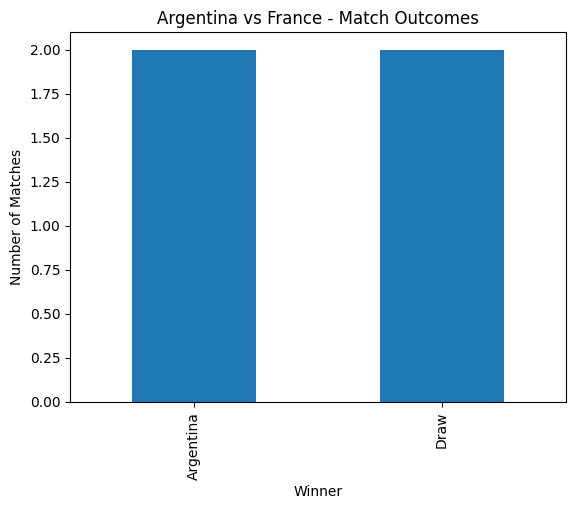

In [62]:
# Feel free to change the teams here! Just double-check that the names match exactly (spelling matters)

analyze_team_rivalry("Argentina", "France", conn)


In [57]:
#now i will try to analyze each team's performance in the last 4 World Cups (2006, 2010, 2014, 2018, and 2022) 

In [63]:
# Retrieve match results from the last 5 World Cups (2006–2022) for team performance analysis
query = """
SELECT 
    home_team,
    away_team,
    home_goal_count,
    away_goal_count,
    match_result,
    Year
FROM clean_matches
WHERE Year IN (2006, 2010, 2014, 2018, 2022)
"""
df = pd.read_sql_query(query, conn)


In [ ]:
# Create home team rows
home_df = df[['home_team', 'home_goal_count', 'away_goal_count', 'match_result', 'Year']].copy()
home_df.rename(columns={
    'home_team': 'team',
    'home_goal_count': 'goals_for',
    'away_goal_count': 'goals_against'
}, inplace=True)

# Determine result (Win, Loss or Draw) for the home team based on the match outcome
home_df['result'] = home_df.apply(lambda row: 'Win' if row['match_result'] == row['team']
                                  else ('Loss' if row['match_result'] != 'Draw' else 'Draw'), axis=1)

# Do the same for away teams —> convert their view of each match into a row
away_df = df[['away_team', 'away_goal_count', 'home_goal_count', 'match_result', 'Year']].copy()
away_df.rename(columns={
    'away_team': 'team',
    'away_goal_count': 'goals_for',
    'home_goal_count': 'goals_against'
}, inplace=True)

# Determine result (Win, Loss or Draw) for the away team
away_df['result'] = away_df.apply(lambda row: 'Win' if row['match_result'] == row['team']
                                  else ('Loss' if row['match_result'] != 'Draw' else 'Draw'), axis=1)

# Combine home and away rows so we can analyze team performance regardless of match location
all_matches = pd.concat([home_df, away_df], ignore_index=True)


In [69]:
# Summarize overall team performance across all matches
# We'll calculate total matches, wins, draws, losses, and goals

team_year_stats = all_matches.groupby(['team', 'Year']).agg(
    Matches=('result', 'count'),
    Wins=('result', lambda x: (x == 'Win').sum()),
    Draws=('result', lambda x: (x == 'Draw').sum()),
    Losses=('result', lambda x: (x == 'Loss').sum()),
    Goals_For=('goals_for', 'sum'),
    Goals_Against=('goals_against', 'sum')
).reset_index()


# Calculate win percentage
#team_stats['Win_%'] = (team_stats['Wins'] / team_stats['Matches']) * 100
team_year_stats['Win_%'] = (team_year_stats['Wins'] / team_year_stats['Matches']) * 100


# Sort by most wins or best win %
team_stats = team_stats.sort_values(by='Wins', ascending=False)

print(team_year_stats.head(10).to_string())


        team  Year  Matches  Wins  Draws  Losses  Goals_For  Goals_Against      Win_%
0    Algeria  2010        3     0      1       2          0              2   0.000000
1    Algeria  2014        4     1      1       2          6              7  25.000000
2     Angola  2006        3     0      2       1          1              2   0.000000
3  Argentina  2006        5     2      3       0         10              3  40.000000
4  Argentina  2010        5     4      0       1          9              6  80.000000
5  Argentina  2014        7     4      2       1          7              4  57.142857
6  Argentina  2018        4     1      2       1          6              7  25.000000
7  Argentina  2022        7     5      0       2         11              5  71.428571
8  Australia  2006        4     1      1       2          4              5  25.000000
9  Australia  2010        3     2      0       1          3              5  66.666667


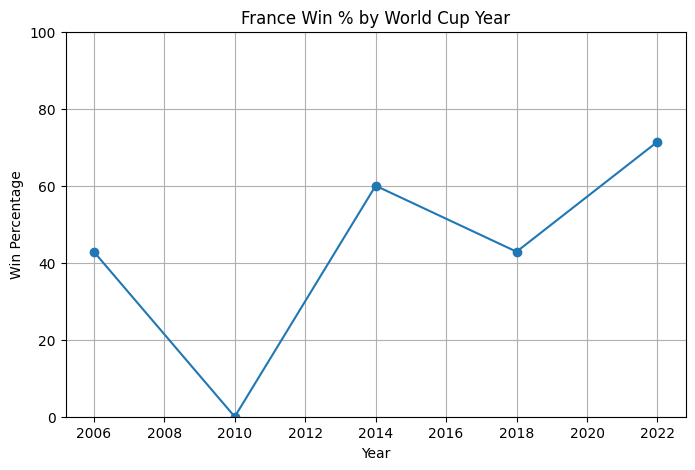

In [ ]:
# Filter data for one team, we can have for multiple teams 
team_name = "France"
france_stats = team_year_stats[team_year_stats['team'] == team_name]

# If we want to have multiple team shown
#top_teams = ['France', 'Argentina', 'Brazil', 'Germany']

#plt.figure(figsize=(10, 6))

#for team in top_teams:
    #stats = team_year_stats[team_year_stats['team'] == team]
    #plt.plot(stats['Year'], stats['Win_%'], marker='o', label=team)

#plt.title("Win Percentage Over Time (Top Teams)")
#plt.xlabel("Year")
#plt.ylabel("Win Percentage")
#plt.legend()
#plt.grid(True)
#plt.show()





# Plot win % over the years
plt.figure(figsize=(8, 5))
plt.plot(france_stats['Year'], france_stats['Win_%'], marker='o')
plt.title(f"{team_name} Win % by World Cup Year")
plt.xlabel("Year")
plt.ylabel("Win Percentage")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

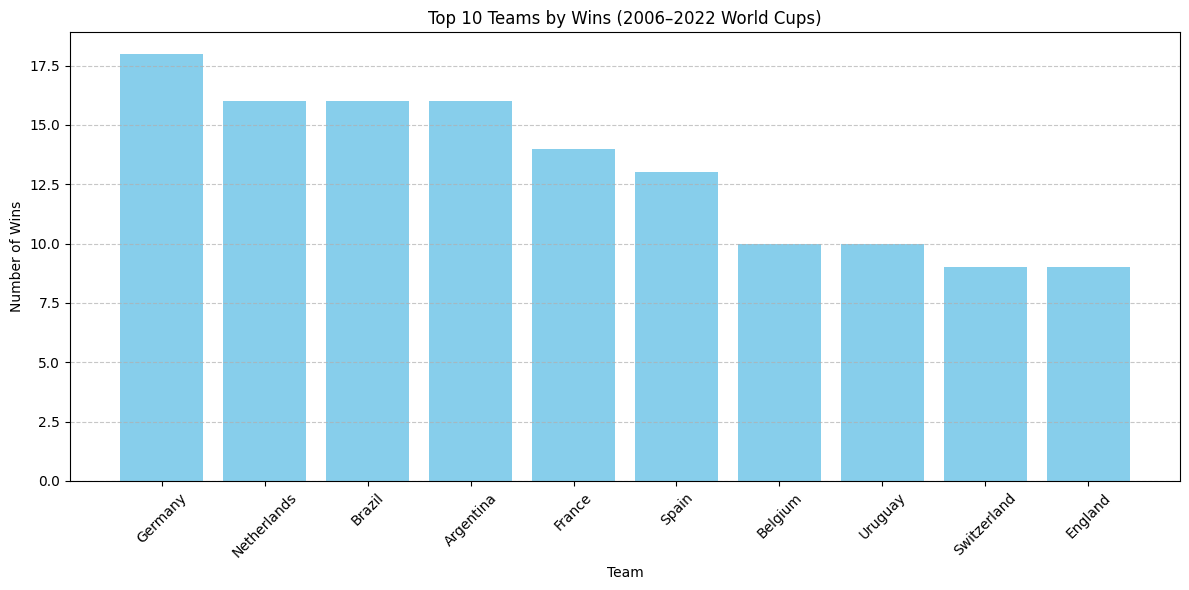

In [71]:


# Plot the top 10 teams with the most wins from World Cups between 2006 and 2022

# Select top 10 teams by number of wins
top_teams = team_stats.sort_values(by='Wins', ascending=False).head(10)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_teams.index, top_teams['Wins'], label='Wins', color='skyblue')

# Add chart details
plt.title('Top 10 Teams by Wins (2006–2022 World Cups)')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format layout and show
plt.tight_layout()
plt.show()



In [ ]:
# Assign a numerical value to each round to measure team progression in the tournament
# Higher values = deeper into the tournament (e.g., Final = 7, Group stage = 1)
round_order = {
    "Group stage": 1,
    "First round": 1,
    "Second round": 2,
    "Round of 16": 3,
    "Quarter-finals": 4,
    "Semi-finals": 5,
    "Third place": 6,
    "Final": 7
}
query = """
SELECT home_team, away_team, match_result, Round, Year
FROM clean_matches
WHERE Year IN (2006, 2010, 2014, 2018, 2022)
"""
df = pd.read_sql_query(query, conn)

# Map each match’s round name to its corresponding numeric rank
df['round_rank'] = df['Round'].map(round_order)

In [ ]:
# What can we do Instead of hardcoding the last 5 World Cup years?
# We can find them dynamically
# Step 1: Get the last 5 unique tournament years from the database
years_df = pd.read_sql_query("SELECT DISTINCT Year FROM clean_matches ORDER BY Year DESC LIMIT 5", conn)
recent_years = sorted(years_df['Year'].tolist())  # sort to keep ascending order (e.g., 2006 → 2022)

# Step 2: Convert the list of years into a tuple for the SQL IN clause
year_tuple = tuple(recent_years)

# Step 3: Use those years in your query to fetch relevant matches
query = f"""
SELECT home_team, away_team, match_result, Round, Year
FROM clean_matches
WHERE Year IN {year_tuple}
"""
df = pd.read_sql_query(query, conn)


In [78]:
# Assign numeric values to each round to measure how far teams progressed in the tournament
# Higher numbers mean later stages (e.g. Final = 7, Group stage = 1)
round_order = {
    "Group stage": 1,
    "First round": 1,
    "Second round": 2,
    "Round of 16": 3,
    "Quarter-finals": 4,
    "Semi-finals": 5,
    "Third place": 6,
    "Final": 7
}

# Map each match’s round to its progression rank
df['round_rank'] = df['Round'].map(round_order)


In [79]:
# Re-map with correct dictionary
df['round_rank'] = df['Round'].map(round_order)

# Create both home/away team appearances
home_df = df[['home_team', 'Year', 'round_rank']].rename(columns={'home_team': 'team'})
away_df = df[['away_team', 'Year', 'round_rank']].rename(columns={'away_team': 'team'})
all_teams = pd.concat([home_df, away_df], ignore_index=True)

# Get max round for each team each year
team_stage = all_teams.groupby(['team', 'Year']).agg(Max_Stage=('round_rank', 'max')).reset_index()

# Reverse for stage names
reverse_round_map = {v: k for k, v in round_order.items()}
team_stage['Stage_Name'] = team_stage['Max_Stage'].map(reverse_round_map)

# Pivot for final output
team_pivot = team_stage.pivot(index='team', columns='Year', values='Stage_Name').fillna('—')
print(team_pivot.head(10))



Year                              2006            2010            2014  \
team                                                                     
Algeria                              —     First round     Round of 16   
Angola                     First round               —               —   
Argentina               Quarter-finals  Quarter-finals           Final   
Australia                  Round of 16     First round     First round   
Belgium                              —               —  Quarter-finals   
Bosnia and Herzegovina               —               —     First round   
Brazil                  Quarter-finals  Quarter-finals     Semi-finals   
Cameroon                             —     First round     First round   
Canada                               —               —               —   
Chile                                —     Round of 16     Round of 16   

Year                              2018            2022  
team                                                  

In [ ]:
# Show the full path to victory for a World Cup winning team
# Displays each match played by the winner in chronological round order (e.g. group stage → final)

In [80]:
def winner_road_to_glory(winner_team, year, conn):
    query = f"""
    SELECT 
        home_team, away_team, home_goal_count, away_goal_count, match_result, Round
    FROM clean_matches
    WHERE Year = {year}
    AND (home_team = '{winner_team}' OR away_team = '{winner_team}')
    ORDER BY 
        CASE
            WHEN Round = 'Group stage' THEN 1
            WHEN Round = 'First round' THEN 1
            WHEN Round = 'Second round' THEN 2
            WHEN Round = 'Round of 16' THEN 3
            WHEN Round = 'Quarter-finals' THEN 4
            WHEN Round = 'Semi-finals' THEN 5
            WHEN Round = 'Third place' THEN 6
            WHEN Round = 'Final' THEN 7
            ELSE 8
        END
    """
    journey = pd.read_sql_query(query, conn)
    print(f"\n {winner_team} Road to World Cup Victory ({year})")
    print(journey.to_string(index=False))


In [81]:
# Loop through all final winners and show their path
for index, row in winners.iterrows():
    winner_road_to_glory(row['winner'], row['Year'], conn)



 Argentina Road to World Cup Victory (2022)
  home_team    away_team  home_goal_count  away_goal_count match_result          Round
     Poland    Argentina                0                2    Argentina    Group stage
  Argentina       Mexico                2                0    Argentina    Group stage
  Argentina Saudi Arabia                0                2 Saudi Arabia    Group stage
  Argentina    Australia                2                0    Argentina    Round of 16
Netherlands    Argentina                2                1  Netherlands Quarter-finals
  Argentina      Croatia                2                0    Argentina    Semi-finals
  Argentina       France                2                1    Argentina          Final

 France Road to World Cup Victory (2018)
home_team away_team  home_goal_count  away_goal_count match_result          Round
  Denmark    France                0                0         Draw    Group stage
   France      Peru                1                0

In [ ]:
# Summary & Conclusion

In this notebook, I explored FIFA World Cup data from 2006 to 2022 to analyze team performance, progression, and championship paths. Here's a quick recap of what was done:

- Loaded and cleaned match data
- Calculated goal counts and match results
- Analyzed top teams by wins, goals, and win percentages
- Tracked the tournament journeys of World Cup winners
- Visualized team performance over time
- Dynamically handled tournament years for future-proof analysis

This project highlights how structured data analysis and SQL integration can be used to tell powerful stories in sports analytics.

---

Next steps (I may handle it later):
- Add player-level data if available
- Predict future outcomes using ML
- Create an interactive dashboard

Thanks for exploring this with me!
